In [1]:
%pip install --quiet jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [4]:
%sql duckdb:///./383580.duckdb

Connecting to 'duckdb:///./383580.duckdb'

In [5]:
%sqlcmd tables

Name
Gateway
Site
Node
Message
Trace
Radio
Power_Consumption
Downlink_Event_Error_Message
Join_Message
Content_Message


In [6]:
%sql select * from Trace

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-11-14 12:52:19.215991,"�c��!�KF[������y""��[auto_init_saul] initializi..."
1,2,70B3D57ED005E88A,2023-11-14 12:52:19.219034,[auto_init_saul] initializing GPIO #1\n
2,3,70B3D57ED005E88A,2023-11-14 12:52:19.222909,[auto_init_saul] initializing GPIO #2\n
3,4,70B3D57ED005E88A,2023-11-14 12:52:19.225900,[auto_init_saul] initializing GPIO #3\n
4,5,70B3D57ED005E88A,2023-11-14 12:52:19.229834,[auto_init_saul] initializing hts221 #0\n
...,...,...,...,...
578,579,70B3D57ED005E88A,2023-11-14 12:56:55.637990,[semtech-loramac] Transmission completed\n
579,580,70B3D57ED005E88A,2023-11-14 12:56:56.588764,[semtech-loramac] MAC timer timeout\n
580,581,70B3D57ED005E88A,2023-11-14 12:56:57.593049,[semtech-loramac] MAC timer timeout\n
581,582,70B3D57ED005E88A,2023-11-14 12:56:58.596054,[semtech-loramac] MAC timer timeout\n


In [7]:
%sql nodes =<< select distinct * from Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board
0,70B3D57ED005E88A,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1


In [8]:

timestamps= %sql select timestamp from Power_Consumption 
#timestamps = timestamps["timestamp"].map(lambda x: x.isoformat())
%sql SUMMARIZE Power_Consumption

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,power_consumption_id,INTEGER,1,281264,283642,140632.5,81194.06739411499,70758,140410,211488,281264,0.0%
1,node_id,VARCHAR,70B3D57ED005E88A,70B3D57ED005E88A,1,None,None,None,None,None,281264,0.0%
2,timestamp,TIMESTAMP,2023-11-14 12:51:54.21604,2023-11-14 12:56:59.953919,283044,None,None,None,None,None,281264,0.0%
3,current,FLOAT,-0.012356,0.162825,1181,0.057506714405233424,0.007048726877472174,0.05584519562155994,0.05640401717781954,0.05702639356361112,281264,0.0%
4,voltage,FLOAT,1.5775,4.93,345,4.8550488437427965,0.11821038425323965,4.858749866485596,4.860000133514404,4.861249923706055,281264,0.0%
5,power,FLOAT,0.0,0.797886,393,0.279491417294811,0.03421101185813189,0.27165645801696225,0.27410200238227844,0.27715399861335754,281264,0.0%


In [9]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from Power_Consumption group by node_id

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005E88A,281264,2023-11-14 12:51:54.216040,2023-11-14 12:56:59.953919


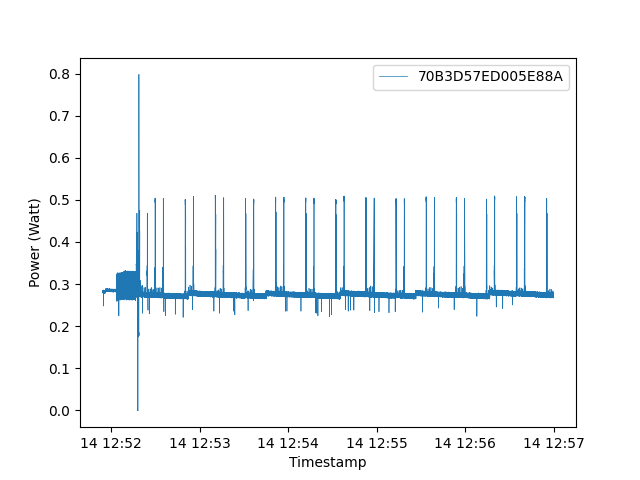

In [10]:
deveui = "70B3D57ED005EA56"

power_consumption= %sql select timestamp,power,current,voltage,node_id from Power_Consumption
power_consumption = power_consumption.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power_consumption.groupby("node_id")
plt.figure()
for node_id, group in groups:
    plt.plot(group.index, group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.legend()
plt.show()

## finding sync signals

In [11]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

#diff of each group
power_consumption['power_diff'] = groups["power"].diff()
power_diff = power_consumption['power_diff']

# single node
power_single = power_consumption[(power_consumption["node_id"] =="70B3D57ED005E88A")]


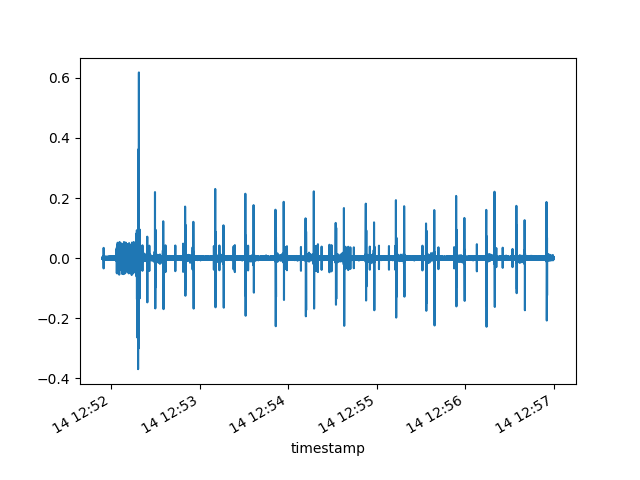

In [12]:
plt.figure()
power_diff.plot()
plt.show()

In [13]:
rising_edge = power_consumption[power_diff > 0.02].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_diff < -0.02].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2023-11-14 12:51:54.953015,0.247851,0.057702,4.86250,70B3D57ED005E88A,-0.034187,falling
2023-11-14 12:51:54.954083,0.282038,0.057946,4.86000,70B3D57ED005E88A,0.034187,rising
2023-11-14 12:52:03.723941,0.315614,0.065027,4.86000,70B3D57ED005E88A,0.031134,rising
2023-11-14 12:52:03.890242,0.269828,0.055455,4.86125,70B3D57ED005E88A,-0.050059,falling
2023-11-14 12:52:03.971776,0.297910,0.061242,4.85875,70B3D57ED005E88A,0.037239,rising


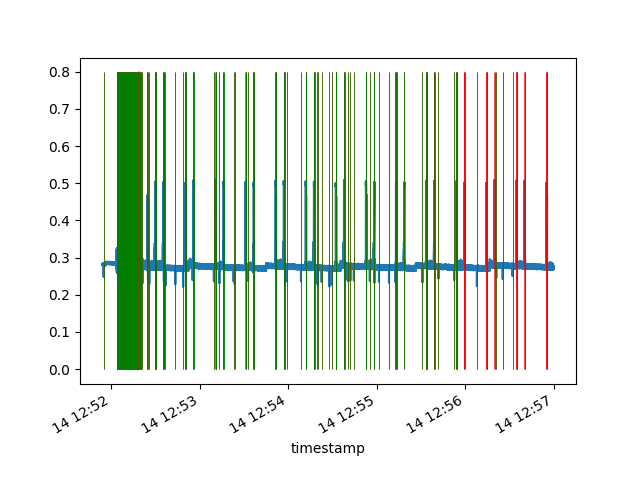

In [14]:
plt.figure()
power_single['power'].plot(label="power")
plt.vlines(edges[edges['direction'] == 'rising'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.vlines(edges[edges['direction'] == 'falling'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5)

plt.show()

In [15]:
# only keep edges where direction differ
edges['next_direction'] = edges['direction'].shift(-1)
edges['next_timestamp'] = edges.index.to_series().shift(-1)
edges = edges[(edges['direction'] != edges['next_direction']) & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=210))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=190)))]
edges.head()


,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp
timestamp,,,,,,,,
2023-11-14 12:52:29.778172,0.495703,0.102046,4.85375,70B3D57ED005E88A,0.219770,rising,falling,2023-11-14 12:52:29.978192
2023-11-14 12:52:35.364286,0.493871,0.101680,4.85750,70B3D57ED005E88A,0.100117,rising,falling,2023-11-14 12:52:35.563207
2023-11-14 12:52:50.198626,0.490209,0.100948,4.85625,70B3D57ED005E88A,0.050670,rising,falling,2023-11-14 12:52:50.397578
2023-11-14 12:52:55.783703,0.499366,0.102828,4.85500,70B3D57ED005E88A,0.100728,rising,falling,2023-11-14 12:52:55.982624
2023-11-14 12:53:10.618073,0.510965,0.105245,4.85750,70B3D57ED005E88A,0.230148,rising,falling,2023-11-14 12:53:10.818093


In [16]:
## add counter to sync signals and add sync signal start and end times
edges.loc[:,'sync_num'] = range(len(edges)) 
edges.loc[:, 'sync_start'] = edges.index - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num,sync_start,sync_end
timestamp,,,,,,,,,,,
2023-11-14 12:52:29.778172,0.495703,0.102046,4.85375,70B3D57ED005E88A,0.219770,rising,falling,2023-11-14 12:52:29.978192,0,2023-11-14 12:52:29.678172,2023-11-14 12:52:30.078192
2023-11-14 12:52:35.364286,0.493871,0.101680,4.85750,70B3D57ED005E88A,0.100117,rising,falling,2023-11-14 12:52:35.563207,1,2023-11-14 12:52:35.264286,2023-11-14 12:52:35.663207
2023-11-14 12:52:50.198626,0.490209,0.100948,4.85625,70B3D57ED005E88A,0.050670,rising,falling,2023-11-14 12:52:50.397578,2,2023-11-14 12:52:50.098626,2023-11-14 12:52:50.497578
2023-11-14 12:52:55.783703,0.499366,0.102828,4.85500,70B3D57ED005E88A,0.100728,rising,falling,2023-11-14 12:52:55.982624,3,2023-11-14 12:52:55.683703,2023-11-14 12:52:56.082624
2023-11-14 12:53:10.618073,0.510965,0.105245,4.85750,70B3D57ED005E88A,0.230148,rising,falling,2023-11-14 12:53:10.818093,4,2023-11-14 12:53:10.518073,2023-11-14 12:53:10.918093


In [17]:
#based on sync_num add loop timings
edges.loc[:,'loop_num'] = ((edges['sync_num'] - 1) // 2)
edges.head()

,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num,sync_start,sync_end,loop_num
timestamp,,,,,,,,,,,,
2023-11-14 12:52:29.778172,0.495703,0.102046,4.85375,70B3D57ED005E88A,0.219770,rising,falling,2023-11-14 12:52:29.978192,0,2023-11-14 12:52:29.678172,2023-11-14 12:52:30.078192,-1
2023-11-14 12:52:35.364286,0.493871,0.101680,4.85750,70B3D57ED005E88A,0.100117,rising,falling,2023-11-14 12:52:35.563207,1,2023-11-14 12:52:35.264286,2023-11-14 12:52:35.663207,0
2023-11-14 12:52:50.198626,0.490209,0.100948,4.85625,70B3D57ED005E88A,0.050670,rising,falling,2023-11-14 12:52:50.397578,2,2023-11-14 12:52:50.098626,2023-11-14 12:52:50.497578,0
2023-11-14 12:52:55.783703,0.499366,0.102828,4.85500,70B3D57ED005E88A,0.100728,rising,falling,2023-11-14 12:52:55.982624,3,2023-11-14 12:52:55.683703,2023-11-14 12:52:56.082624,1
2023-11-14 12:53:10.618073,0.510965,0.105245,4.85750,70B3D57ED005E88A,0.230148,rising,falling,2023-11-14 12:53:10.818093,4,2023-11-14 12:53:10.518073,2023-11-14 12:53:10.918093,1


In [18]:
# create table of loops by taking every second row and excluding the first edge (which is just program start)
# the index is when (we think) the loop starts. that is 100 ms after next_timestamp.
# also remove all irrelevant columns

loops = edges[['node_id', 'next_timestamp', 'loop_num']].iloc[1::2,:]
## change index to be loop start time. i.e. 200 ms after next timestamp
loops['loop_start'] = loops.next_timestamp + pd.Timedelta(milliseconds=100)
loops.set_index('loop_start', inplace=True)
loops.drop('next_timestamp', axis=1, inplace=True)
loops.head()

,node_id,loop_num
loop_start,,
2023-11-14 12:52:35.663207,70B3D57ED005E88A,0
2023-11-14 12:52:56.082624,70B3D57ED005E88A,1
2023-11-14 12:53:16.503170,70B3D57ED005E88A,2
2023-11-14 12:53:36.922708,70B3D57ED005E88A,3
2023-11-14 12:53:57.342308,70B3D57ED005E88A,4


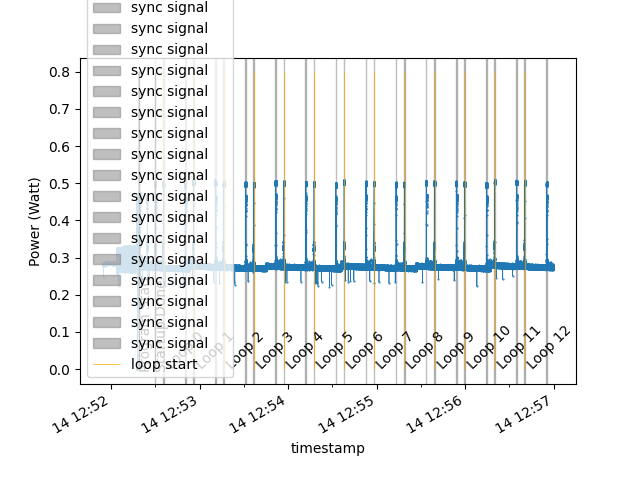

In [19]:
plt.figure()
power_single['power'].plot(style='.',markersize=1, label="power")
power_single['power'].plot(linewidth=0.5, color='tab:blue', label="power")
plt.ylabel("Power (Watt)")
# when does the program start?
%sql program_start << select timestamp from Trace WHERE message LIKE 'Terra%'
%sql startup_done << select timestamp from Trace WHERE message LIKE 'Startup done.%'
# add line indicating program start
plt.vlines(program_start['timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="black", linewidth=1, label="program start")
plt.text(program_start['timestamp'], 0, "Program Start", rotation=90)

# # add line indicating startup done
plt.vlines(startup_done['timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="black", linewidth=1, label="startup done")
plt.text(startup_done['timestamp'], 0, "Startup Done", rotation=90)

## add sync signal indication
for row in edges.itertuples():
    plt.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5, label="sync signal")
# plt.vlines(edges.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5, label="rising edge")
# plt.vlines(edges['next_timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5, label="falling edge")
plt.vlines(loops.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="orange", linewidth=0.5, label="loop start")
for row in loops.itertuples():

    #odd row num indicates start sync
    plt.text(row.Index, 0, f"Loop {row.loop_num}", rotation=45)
plt.legend()
plt.gca().xaxis.set_major_locator(dates.AutoDateLocator())
plt.gca().xaxis.set_minor_locator(dates.AutoDateLocator(minticks=10, maxticks=20))
plt.show()

In [20]:
%%sql
timings << 
select 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: ([0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: ([0-9]+)',1) as sync_time,
    regexp_extract(message, '.*Listen: ([0-9]+)',1) as listen_time,
    regexp_extract(message, '.*Collect: ([0-9]+)',1) as collect_time,
    regexp_extract(message, '.*Exec: ([0-9]+)',1) as exec_time,
    regexp_extract(message, '.*Send: ([0-9]+)',1) as send_time,
    regexp_extract(message, '.*Sleep: ([0-9]+)',1) as sleep_time,
    regexp_extract(message, '.*Total: ([0-9]+)',1) as total_time
     from Trace WHERE message LIKE 'TIMINGS>%'

In [21]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time', 'listen_time', 'collect_time', 'exec_time', 'send_time', 'sleep_time', 'total_time']] = timings[['loop_num', 'sync_time', 'listen_time', 'collect_time', 'exec_time', 'send_time', 'sleep_time', 'total_time']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('loop_start')
loops.head()

,node_id,loop_num,timestamp,sync_time,listen_time,collect_time,exec_time,send_time,sleep_time,total_time
loop_start,,,,,,,,,,
2023-11-14 12:52:35.663207,70B3D57ED005E88A,0,2023-11-14 12:52:35.679203,403,0,28,0,5147,14418,5582
2023-11-14 12:52:56.082624,70B3D57ED005E88A,1,2023-11-14 12:52:56.098520,402,1,28,0,5146,14419,5581
2023-11-14 12:53:16.503170,70B3D57ED005E88A,2,2023-11-14 12:53:16.518664,403,0,28,0,5147,14418,5582
2023-11-14 12:53:36.922708,70B3D57ED005E88A,3,2023-11-14 12:53:36.937905,403,0,28,0,5147,14418,5582
2023-11-14 12:53:57.342308,70B3D57ED005E88A,4,2023-11-14 12:53:57.357162,403,0,28,0,5147,14418,5582


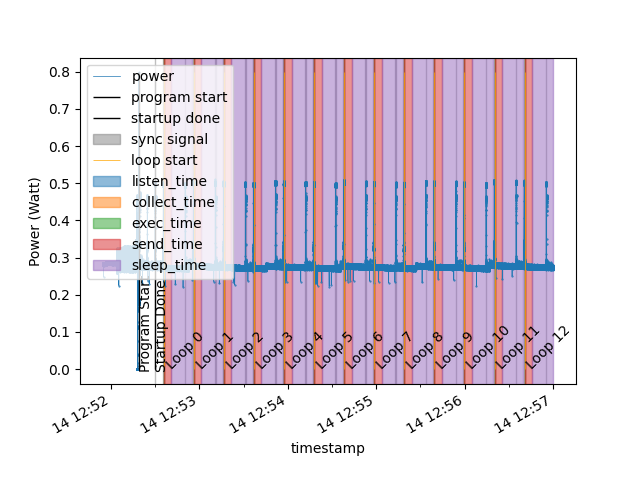

In [22]:
for row in loops.itertuples():
    start_time = row.Index
    listen_time_start = start_time
    listen_time_end = start_time + pd.Timedelta(milliseconds=row.listen_time)
    collect_time_start = listen_time_end
    collect_time_end = collect_time_start + pd.Timedelta(milliseconds=row.collect_time)
    exec_time_start = collect_time_end
    exec_time_end = exec_time_start + pd.Timedelta(milliseconds=row.exec_time)
    send_time_start = exec_time_end
    send_time_end = send_time_start + pd.Timedelta(milliseconds=row.send_time)
    sleep_time_start = send_time_end
    sleep_time_end = sleep_time_start + pd.Timedelta(milliseconds=row.sleep_time)
    plt.axvspan(listen_time_start, listen_time_end, color='tab:blue', alpha=0.5, label="listen_time")
    plt.axvspan(collect_time_start, collect_time_end, color='tab:orange', alpha=0.5, label="collect_time")
    plt.axvspan(exec_time_start, exec_time_end, color='tab:green', alpha=0.5, label="exec_time")
    plt.axvspan(send_time_start, send_time_end, color='tab:red', alpha=0.5, label="send_time")
    plt.axvspan(sleep_time_start, sleep_time_end, color='tab:purple', alpha=0.5, label="sleep_time")
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [23]:
# get all relevant frame-events
%sql send_frame_start << select * from Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from Trace WHERE message LIKE '%received something%'

In [24]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

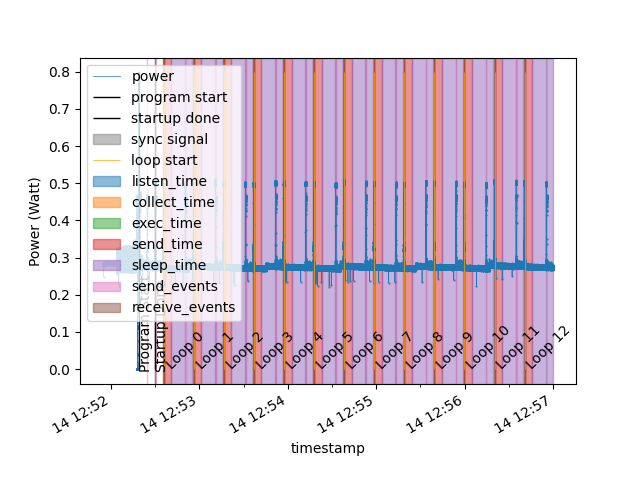

In [25]:
# add send and receive columns to plot

for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
    start_time = send_start_row.timestamp
    end_time = send_end_row.timestamp
    plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
    start_time = receive_frame_start.timestamp
    end_time = receive_frame_end.timestamp
    plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [26]:
%%sql
res <<
select timestamp, AVG(power) OVER blink AS 'avg_power_blink'
FROM Power_Consumption
WINDOW blink AS (
    PARTITION BY node_id
    ORDER BY timestamp ASC
    RANGE BETWEEN INTERVAL 100 MILLISECOND PRECEDING AND INTERVAL 100 MILLISECOND FOLLOWING
    )

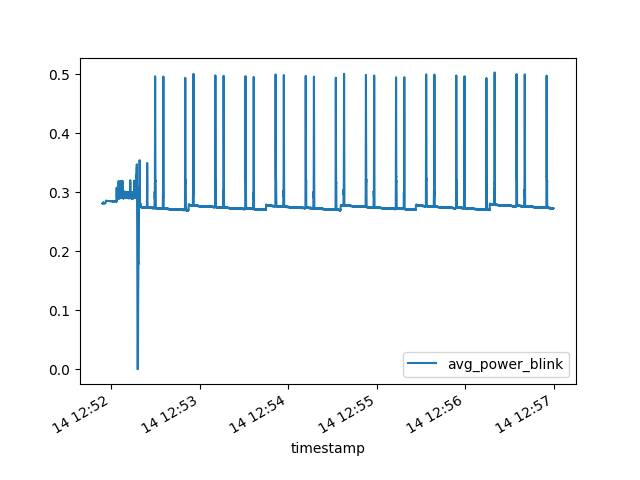

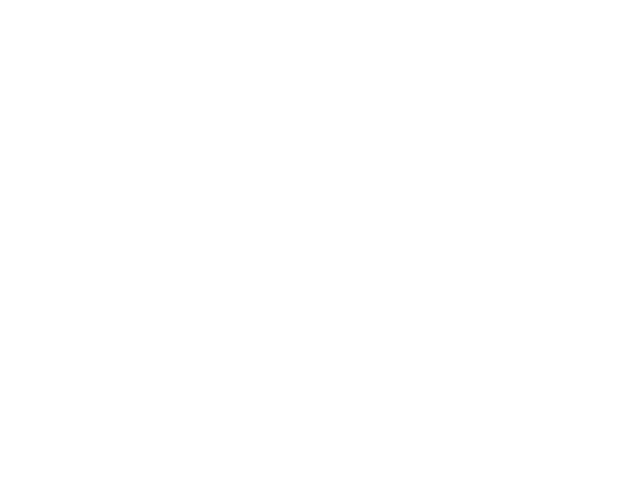

In [27]:
plt.figure()
res.plot(x='timestamp')
plt.show()

In [28]:
# Clean edge detection
#remove values where difference is not greater or less than 5 seconds
diff = filtered_power_diff.index.to_series().diff(-1).abs()
plt.figure()
plt.ylabel("Power")
# single node

power_single["power"].plot()

plt.vlines(filtered_power_diff.index[(diff < pd.Timedelta(seconds=5.5))  & (diff > pd.Timedelta(seconds=4.5))], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.show()

NameError: name 'filtered_power_diff' is not defined

In [ ]:
%sql select count(*) from Trace

,count_star()
0,607


In [ ]:
#traces from single node
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A'

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-11-02 10:44:44.111270,�'/!8@!8UP�����Join procedure succeededcreatin...
1,2,70B3D57ED005E88A,2023-11-02 10:44:44.111979,Sending: <3\n
2,3,70B3D57ED005E88A,2023-11-02 10:44:49.218133,"Startup done. Timings: sensor init: 14 ms, env..."
3,4,70B3D57ED005E88A,2023-11-02 10:44:49.220100,Main loop iteration\n
4,5,70B3D57ED005E88A,2023-11-02 10:44:49.222096,Running single blink...\n
...,...,...,...,...
602,603,70B3D57ED005E88A,2023-11-02 10:49:19.918121,collecting data from sensor lps22hb\n
603,604,70B3D57ED005E88A,2023-11-02 10:49:19.924045,Read value from Sensor lps22hb. Saving in env...
604,605,70B3D57ED005E88A,2023-11-02 10:49:19.926032,Execute Queries...\n
605,606,70B3D57ED005E88A,2023-11-02 10:49:19.928118,Sending Responses if any...\n


In [ ]:
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A' AND message LIKE '>TIMINGS%'

,trace_id,node_id,timestamp,message


In [ ]:
def get_timings_from_trace(trace: str):
    

SyntaxError: incomplete input (2969963752.py, line 2)

In [ ]:
# lower=widgets.SelectionSlider(options=timestamps, value=timestamps.min())
# upper=widgets.SelectionSlider(options=timestamps, value=timestamps.max())
# %sql --save hej --interact deveuis --interact lower --interact upper SELECT * from Power_Consumption where node_id LIKE '{{deveuis}}' AND timestamp BETWEEN '{{lower}}' AND '{{upper}}'